<a href="https://colab.research.google.com/github/sbbwoy/ESAA/blob/main/220513_NLP_Mercari_Price_Suggestion_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mercari Price Suggestion Cahllenge

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* train_id: 데이터 id
* name: 제품명
* item_condition_id: 판매자가 제공하는 제품 상태
* category_name: 카테고리 명
* brand_name: 브랜드 이름
* price: 제품 가격, 예측을 위한 target
* shipping: 배송비 무료 여부. 1이면 무료 / 0이면 유료
* item_description:제품에 대한 설명

##데이터 전처리

In [ ]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/drive/MyDrive/ESAA/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head()

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [ ]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


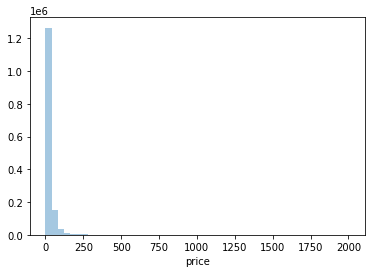

In [ ]:
y_train_df = mercari_df['price']
plt.figure(figsize=(6, 4))
sns.distplot(y_train_df, kde=False)

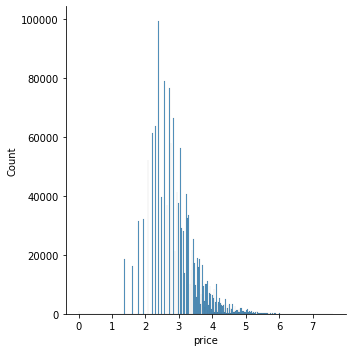

In [ ]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.displot(y_train_df, kde=False)

In [ ]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head()

0    2.397895
1    3.970292
2    2.397895
3    3.583519
4    3.806662
Name: price, dtype: float64

In [ ]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [ ]:
boolean_cond = mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

In [ ]:
#apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중 소 값을 리스트로 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']

#위의 split_cat()을 apple lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

#대분류만 값의 유형과 건수를 살피고, 중분류, 소분류는 분류 개수만 추출
print('대분류 유형: \n', mercari_df['cat_dae'].value_counts())
print('중분류 개수:', mercari_df['cat_jung'].nunique())
print('소분류 개수:', mercari_df['cat_so'].nunique())

대분류 유형: 
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 개수: 114
소분류 개수: 871


In [ ]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value = 'Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value = 'Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value = 'Other_Null')

#각 칼럼별로 Null 값 건수 확인
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

##피처 인코딩과 피처 벡터화

In [ ]:
print('brand name의 유형 건수:', mercari_df['brand_name'].nunique())
print('brand name sample 5건:\n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수: 4810
brand name sample 5건:
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


In [ ]:
print('name의 유형 건수:', mercari_df['name'].nunique())
print('name sample 10건:\n', mercari_df['name'].value_counts()[:10])

name의 유형 건수: 1225273
name sample 10건:
 Bundle                 2232
Reserved                453
Converse                445
BUNDLE                  418
Dress                   410
Coach purse             404
Lularoe TC leggings     396
Romper                  353
Nike                    340
Vans                    334
Name: name, dtype: int64


In [ ]:
pd.set_option('max_colwidth', 200)

#item_description의 평균 문자열 크기
print('item_description의 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())
mercari_df['item_description'][:2]

item_description의 평균 문자열 크기: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [ ]:
#name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

#item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range=(1, 3), stop_words = 'english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


In [ ]:
from sklearn.preprocessing import LabelBinarizer

#brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

#cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 웟-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output = True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output = True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output = True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [ ]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


In [ ]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

#hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

#데이터 세트가 메모리를 많이 차지하므로 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


153

##릿지 회귀 모델 구축 및 평가

* 원본 데이터의 price 칼럼의 값은 왜곡된 데이터 분포를 가져 이를 정규 분포 형태로 유도하기 위해 로그 값을 취해 변환함
* 즉, 학습할 모델이 사용할 price 값은 로그 값으로 변환된 price값이므로 예측도 당연히 로그로 변환한 데이터 값 수준의 price 값을 예측

In [ ]:
def rmsle(y, y_pred):
    #underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
    #원본 데이터는 log1p로 변환되었으므로 exmpm1로 복원 필요
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    #rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [ ]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
    #scipy.sparse 모듈이 hstack을 이용해 희소 행렬 결합
    X = hstack(matrix_list).tocsr()

    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], test_size = 0.2, random_state = 156)

    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    del X, X_train, X_test, y_train
    gc.collect()

    return preds, y_test

In [ ]:
linear_model = Ridge(solver = 'lsqr', fit_intercept=False)
sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model = linear_model, matrix_list = sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.4712196801895368
Item Description을 포함한 rmsle 값: 0.4699613657759145


##LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators = 200, learning_rate = 0.5, num_leaves = 125, random_state = 156)
lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list = sparse_matrix_list)
print('LightGBM rmsle 값:', evaluate_org_price(y_test, lgbm_preds))

LightGBM rmsle 값: 0.45753305614216716


In [ ]:
preds = lgbm_preds *0.45 + linear_preds *0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 1.4871238677980365
